# How to save parameters along with the function 

This is a workaround for the problem of how to save *and restore* the parameters of a workflow (e.g., sigma for blurring, threshold values, etc) along with the functions. The idea is simple:

Instead of setting workflow steps with, for instance, `w.set('blurring', blur_function, 'input', sigma=5)`, this notebook creates a partial function of `blur_function()` which is then added to the workflow. When the workflow is loaded and the partial function is passed to magicgui, the parameters are restored correctly.

In [1]:
from napari_workflows import Workflow
from napari.types import ImageData
import napari
import yaml
from skimage.filters import threshold_otsu, gaussian

import inspect
import magicgui
from functools import partial
from napari_tools_menu import make_gui

### First fix:

Turn function into partial object before putting it into the workflow

In [2]:
w = Workflow()

# define segmentation
def threshold(image: ImageData, value: float = 1) -> ImageData:
    return image > value

def add(imageA: ImageData, imageB:ImageData) -> ImageData:
    return imageA + imageB

def blur(image: ImageData, sigma: float=2):
    return gaussian(image, sigma=sigma)

kwargs = {'sigma': 5}

_blur = partial(blur, **kwargs)

w.set('blurring', _blur, 'input', **kwargs)
w.set('binarization', threshold, 'blurring')


with open('workflow.yaml', 'w') as f:
    yaml.dump(w, f)

In [3]:
with open("workflow.yaml", "rb") as stream:
    w=yaml.unsafe_load(stream)
    
w._tasks

{'binarization': (<function __main__.threshold(image: <function NewType.<locals>.new_type at 0x000002285844E9D0>, value: float = 1) -> <function NewType.<locals>.new_type at 0x000002285844E9D0>>,
  'blurring',
  1),
 'blurring': (functools.partial(<function blur at 0x000002285AF01160>, sigma=5),
  'input',
  5)}

In [4]:
viewer = napari.Viewer()
steps = w._tasks.keys()

for key in w._tasks.keys():
    func = w._tasks[key][0]
    widget = magicgui.magicgui(func)
    viewer.window.add_dock_widget(widget)

If you want to compute separable approximations, please install it with
pip install scikit-tensor-py3


### Second fix:
Turn function into partial object after loading it

In [5]:
w = Workflow()
w.set('blurring', blur, 'input', **kwargs)
w.set('binarization', threshold, 'blurring')

with open('_workflow.yaml', 'w') as f:
    yaml.dump(w, f)

In [6]:
with open("_workflow.yaml", "rb") as stream:
    w=yaml.unsafe_load(stream)
    
w._tasks

{'binarization': (<function __main__.threshold(image: <function NewType.<locals>.new_type at 0x000002285844E9D0>, value: float = 1) -> <function NewType.<locals>.new_type at 0x000002285844E9D0>>,
  'blurring',
  1),
 'blurring': (<function __main__.blur(image: <function NewType.<locals>.new_type at 0x000002285844E9D0>, sigma: float = 2)>,
  'input',
  5)}

In [7]:
func = w._tasks['blurring'][0]
w._tasks['blurring'][1:]

('input', 5)

In [8]:
keyword_list = list(inspect.signature(func).parameters.keys())

kw_dict = {}
for kw, val in zip(keyword_list, w._tasks['blurring'][1:]):
    kw_dict[kw] = val
kw_dict.pop('image')

'input'

We need to retrieve a dictionary with parameter: value from the saved function

In [9]:
func = partial(w._tasks['blurring'][0], **kw_dict)

In [10]:
func

functools.partial(<function blur at 0x000002285AF01160>, sigma=5)

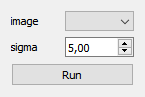

In [11]:
viewer = napari.Viewer()
widget = make_gui(func, viewer)
viewer.window.add_dock_widget(widget)